In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.se = SELayer(32)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(32, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.se(x)
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 16, 16]          64
│    └─ReLU: 2-7                         [64, 32, 16, 16]          --
│    └─Dropout2d: 2-8                    [64, 32, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 32, 8, 8]            --
├─SELayer: 

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 1.0988 Acc: 0.3138
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 1.0592 Acc: 0.4595


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.02it/s]


val Loss: 1.0687 Acc: 0.4524
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.9942 Acc: 0.5636


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.77it/s]


val Loss: 0.9815 Acc: 0.6167
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


train Loss: 0.9645 Acc: 0.5836


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.92it/s]


val Loss: 0.9858 Acc: 0.5000
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.9507 Acc: 0.5956


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.05it/s]


val Loss: 0.9541 Acc: 0.5810
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.83it/s]


train Loss: 0.9354 Acc: 0.6116


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.96it/s]


val Loss: 0.9344 Acc: 0.6152
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]


train Loss: 0.9303 Acc: 0.6196


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.80it/s]


val Loss: 0.9606 Acc: 0.5814
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 0.9168 Acc: 0.6296


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.84it/s]


val Loss: 0.8841 Acc: 0.6729
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.78it/s]


train Loss: 0.9272 Acc: 0.6146


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.92it/s]


val Loss: 0.8513 Acc: 0.7281
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


train Loss: 0.9038 Acc: 0.6436


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.81it/s]


val Loss: 0.9074 Acc: 0.6319
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.59it/s]


train Loss: 0.9151 Acc: 0.6276


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.62it/s]


val Loss: 0.8830 Acc: 0.6733
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8871 Acc: 0.6717


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.60it/s]


val Loss: 0.9659 Acc: 0.5624
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


train Loss: 0.8857 Acc: 0.6707


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.61it/s]


val Loss: 0.8347 Acc: 0.7414
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


train Loss: 0.8972 Acc: 0.6567


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.83it/s]


val Loss: 0.8412 Acc: 0.7276
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.8845 Acc: 0.6677


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.54it/s]


val Loss: 0.8579 Acc: 0.6871
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.80it/s]


train Loss: 0.8822 Acc: 0.6747


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


val Loss: 0.8177 Acc: 0.7610
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.8724 Acc: 0.6767


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.8198 Acc: 0.7533
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.81it/s]


train Loss: 0.8784 Acc: 0.6837


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.87it/s]


val Loss: 0.8266 Acc: 0.7419
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.78it/s]


train Loss: 0.8753 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


val Loss: 0.8440 Acc: 0.7210
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


train Loss: 0.8638 Acc: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.74it/s]


val Loss: 0.8140 Acc: 0.7562
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.8621 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.86it/s]


val Loss: 0.8534 Acc: 0.7038
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


train Loss: 0.8584 Acc: 0.7037


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.79it/s]


val Loss: 0.8050 Acc: 0.7581
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8562 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.8332 Acc: 0.7119
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8584 Acc: 0.7037


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


val Loss: 0.8024 Acc: 0.7671
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.8498 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.98it/s]


val Loss: 0.8269 Acc: 0.7305
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]


train Loss: 0.8411 Acc: 0.7157


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


val Loss: 0.8004 Acc: 0.7648
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.81it/s]


train Loss: 0.8534 Acc: 0.6927


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.01it/s]


val Loss: 0.8181 Acc: 0.7267
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.8366 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


val Loss: 0.8439 Acc: 0.7038
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.8403 Acc: 0.7127


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.7878 Acc: 0.7790
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.83it/s]


train Loss: 0.8446 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.8108 Acc: 0.7610
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


train Loss: 0.8275 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.00it/s]


val Loss: 0.7914 Acc: 0.7776
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


train Loss: 0.8318 Acc: 0.7177


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.8188 Acc: 0.7510
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


train Loss: 0.8383 Acc: 0.7117


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.81it/s]


val Loss: 0.8293 Acc: 0.7400
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.81it/s]


train Loss: 0.8391 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.94it/s]


val Loss: 0.7911 Acc: 0.7714
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 0.8323 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.86it/s]


val Loss: 0.8062 Acc: 0.7638
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8316 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.8550 Acc: 0.6924
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


train Loss: 0.8253 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.96it/s]


val Loss: 0.7884 Acc: 0.7705
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 0.8323 Acc: 0.7257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.84it/s]


val Loss: 0.8046 Acc: 0.7462
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


train Loss: 0.8251 Acc: 0.7247


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.8186 Acc: 0.7214
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


train Loss: 0.8242 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.87it/s]


val Loss: 0.7631 Acc: 0.8010
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.81it/s]


train Loss: 0.8325 Acc: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.94it/s]


val Loss: 0.7737 Acc: 0.7900
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


train Loss: 0.8211 Acc: 0.7357


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


val Loss: 0.8406 Acc: 0.7038
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.83it/s]


train Loss: 0.8273 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.88it/s]


val Loss: 0.7788 Acc: 0.7862
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8089 Acc: 0.7518


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.78it/s]


val Loss: 0.7851 Acc: 0.7676
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.81it/s]


train Loss: 0.8155 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.83it/s]


val Loss: 0.8359 Acc: 0.7181
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]


train Loss: 0.8114 Acc: 0.7447


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.89it/s]


val Loss: 0.7975 Acc: 0.7586
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.81it/s]


train Loss: 0.8113 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.86it/s]


val Loss: 0.8020 Acc: 0.7576
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


train Loss: 0.8048 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.94it/s]


val Loss: 0.7672 Acc: 0.7886
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.8245 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.98it/s]


val Loss: 0.7860 Acc: 0.7629
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.8080 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.85it/s]

val Loss: 0.7895 Acc: 0.7629


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

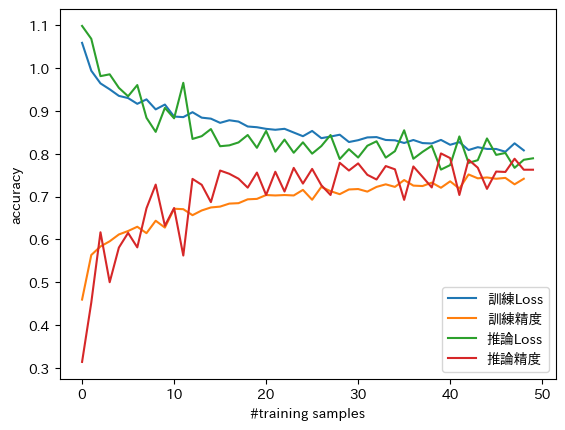

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

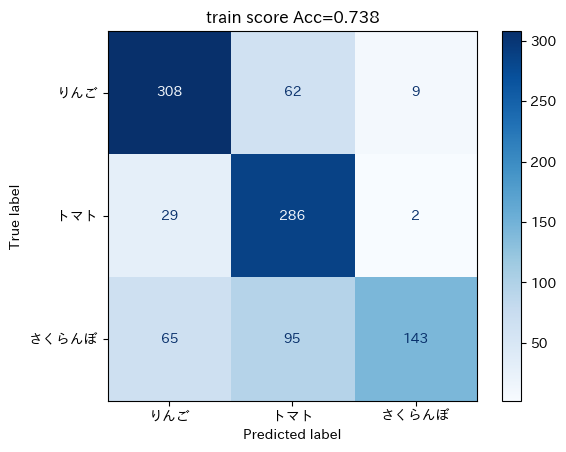

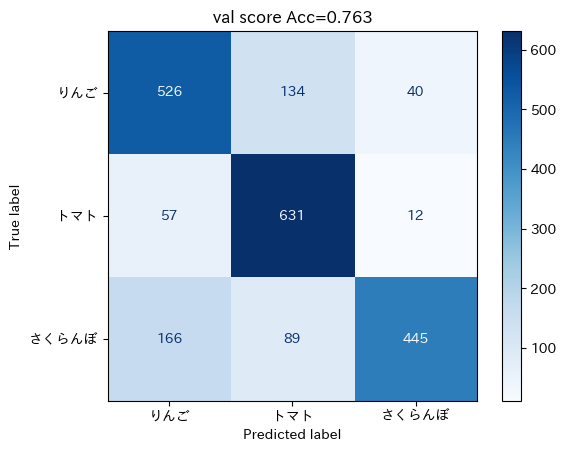

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

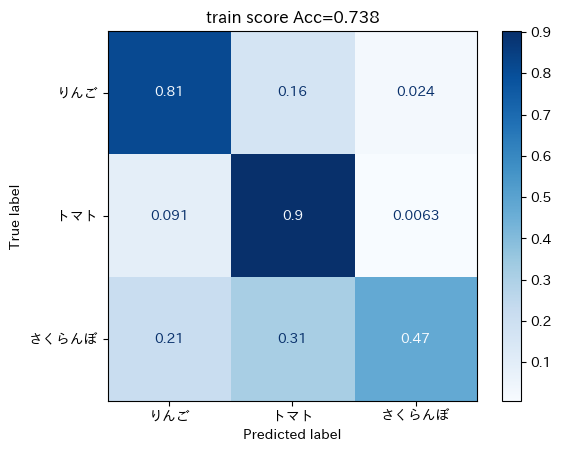

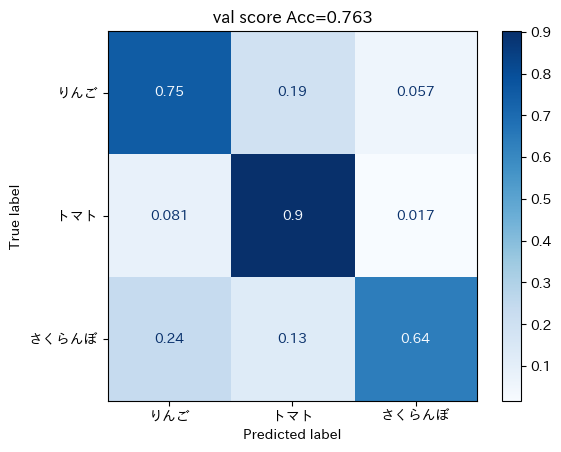

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()